In [1]:
import pandas as pd
import os
from tqdm import tqdm
import argparse
import yaml
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import bokeh
from scipy.signal import find_peaks

from utils import *
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
config = yaml.safe_load(open('/Users/ursic/PhD/Projects/1_DataAnalysis_zebrafish/beads_in_zebrafish/magnetic_tweezers_SD/config.yml'))

filepath_measurements_info = config['filepath_measurements_info']
dir_plots = os.path.join(config['dir_parent'], '3_plots')  # Folder for saving plots
dir_analysis = os.path.join(config['dir_parent'], '2_analysis')  # Folder for saving analysis results
recalculate = config['recalculate']  # Whether to recalculate measurements if they already exist
pix_size = config['pix_size']
dt = config['dt'] 

In [3]:
df_general_info = pd.read_csv(filepath_measurements_info, delimiter=';', encoding='utf-8')
df_general_info = df_general_info.sort_values(by='trackmate_file')
df_general_info.head()

,trackmate_file,MTs,first_pulse (frame),last_pulse (frame),t_on (frame),t_off (frame),tip_x,tip_y,calibration (mV),bead_type,time_interval (s),comments
0,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,131,251,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
1,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,169,249,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
2,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,13,653,10,30,53,314,1000,2.8 um myc dyna passivated PEG,0.5,NaN
3,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,11,611,10,30,57,360,1000,2.8 um myc dyna passivated PEG,0.5,"one bead stuck during pulses 7,8,9,10"
4,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,11,531,10,30,82,254,1000,2.8 um myc dyna passivated PEG,0.5,NaN


In [4]:
save_to_server = True

  0%|          | 0/24 [00:00<?, ?it/s]/Users/ursic/PhD/Projects/1_DataAnalysis_zebrafish/beads_in_zebrafish/magnetic_tweezers_SD/utils.py:230: RuntimeWarning: overflow encountered in exp
  x_2 = F_0 / k * (1 - np.exp(-k * t_1 / eta)) * (np.exp(-(t-t_1) * k / eta))
/Users/ursic/PhD/Projects/1_DataAnalysis_zebrafish/beads_in_zebrafish/magnetic_tweezers_SD/utils.py:211: RuntimeWarning: overflow encountered in exp
  x_2 = (F_0 / k * (1 - np.exp(-k * t_1 / eta_1)) + F_0 * t_1 / eta_2) * (a * np.exp(-(t-t_1) * k / eta_1) + (1-a))
  4%|▍         | 1/24 [02:50<1:05:26, 170.72s/it]


KeyboardInterrupt: 

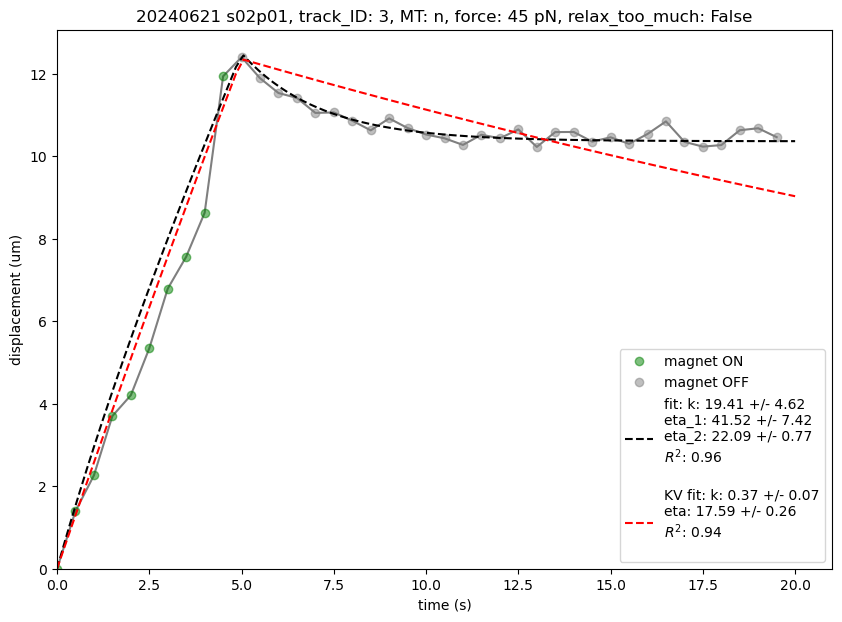

In [ ]:
dir_measurements_extended = dir_analysis+'/measurements_extended_info/'

df_results = pd.DataFrame()

count_failed = 0
for filename in tqdm(os.listdir(dir_measurements_extended)):
    df = pd.read_hdf(dir_measurements_extended+filename, key='df')
    df = df.sort_values(by='POSITION_T')

    for track_id in df['TRACK_ID'].unique():
        track = df[df['TRACK_ID']==track_id]
        for pulse_n in track['PULSE_NUMBER'].unique():

            pulse = track[track['PULSE_NUMBER']==pulse_n]
            time_on = pulse.loc[pulse['MAGNET_STATUS']==1, 'FRAME'].values * dt
            time_off = pulse.loc[pulse['MAGNET_STATUS']==0, 'FRAME'].values * dt

            if len(time_on) < 4 or len(time_off) < 10:
                continue
            
            # normalize time to start at 0
            time_off -= time_on[0]
            time_on -= time_on[0]
            time_data = np.concatenate((time_on, time_off))

            displacement_magnet_on = pulse.loc[pulse['MAGNET_STATUS']==1, 'CORRECTED DISPLACEMENT [um]'].values
            displacement_magnet_off = pulse.loc[pulse['MAGNET_STATUS']==0, 'CORRECTED DISPLACEMENT [um]'].values

            # check if too many data points go below zero during relaxation
            relax_too_much = False
            if sum(displacement_magnet_off < 0)/len(displacement_magnet_off) > 0.5:
                relax_too_much = True
            displacement_full = np.concatenate((displacement_magnet_on, displacement_magnet_off))
            if np.all(np.isnan(displacement_full)):
                continue

            avg_force = np.average(pulse.loc[pulse['MAGNET_STATUS']==1, 'FORCE [pN]'].values)

            t_1 = time_on[-1]
            
            # Soemtimes the magnet was still on after the last frame 
            if displacement_full[len(time_on)] > displacement_full[(len(time_on) - 1)]:
                t_1 = time_off[0]

            # weights for a better fit
            sigma = np.ones_like(displacement_full)
            sigma[:4] = 0.3
            window = 8
            sigma[len(time_on) - int(window//4):len(time_on) + int(3*window//4)] = 0.3*np.ones(int(window//4) + int(3*window//4))
            sigma[len(time_on)-1:len(time_on)+2] = 0.1*np.ones(3)

            fig = plt.figure(figsize=(10, 7))
            plt.plot(time_data, displacement_full, 'k-', alpha = 0.5)
            plt.plot(time_on, displacement_magnet_on, 'o', color ='green', alpha=0.5, label = 'magnet ON')
            plt.plot(time_off, displacement_magnet_off, 'o', color='gray', alpha=0.5, label = 'magnet OFF')

            k, eta_1, eta_2, k_err, eta_1_err, eta_2_err, R_sq = calculate_Jeff_fit_params(time_data, displacement_full, avg_force, t_1, dt, sigma, plot=True)

            k_KV, eta_KV, k_KV_err, eta_KV_err, R_sq_KV = calculate_KV_fit_params(time_data, displacement_full, avg_force, t_1, dt, sigma, plot=True)

            plt.xlabel('time (s)')
            plt.ylabel('displacement (um)')
            plt.title(f'{filename.split("_")[0]} {filename.split("_")[1][0:6]}, track_ID: {track_id}, MT: {pulse["MT_STATUS"].values[0]}, force: {int(avg_force)} pN, relax_too_much: {relax_too_much}')
            plt.legend()
            plt.xlim(left=0)
            plt.ylim(bottom=0)
            if not os.path.exists(dir_plots + f'all_fits/'):
                os.makedirs(dir_plots + f'all_fits/')
            plt.savefig(dir_plots + f'/all_fits/Jeff_fit_{filename.split("_")[0]}_{filename.split("_")[1][0:6]}_track_ID_{track_id}_pulse_n_{pulse_n}.png')
            plt.close()

            fit_divisible = check_differentiable(time_data, k, eta_1, eta_2, avg_force, t_1, dt)
            
            # include model independent analysis
            rising_dif, relaxing_dif, rising_dif_norm, rising_dif_norm_inverse = calculate_model_independedt_params(pulse, avg_force)

            new_line = {'EMBRYO': [filename.split('_')[0]+filename.split('_')[1][0:6]], 
                        'TRACK_ID': track_id, 
                        'PULSE_NUMBER': pulse_n, 
                        'MT_STATUS': pulse['MT_STATUS'].unique(), 
                        'AVG_FORCE': avg_force,
                        'k': k, 
                        'eta_1': eta_1, 
                        'eta_2': eta_2, 
                        'k_err': k_err, 
                        'eta_1_err': eta_1_err, 
                        'eta_2_err': eta_2_err,
                        'k_KV': k_KV,
                        'eta_KV': eta_KV,
                        'k_KV_err': k_KV_err,
                        'eta_KV_err': eta_KV_err,
                        't_1': t_1,
                        'R_SQUARED': R_sq, 
                        'R_SQUARED_KV': R_sq_KV,
                        'fit_divisible': fit_divisible,
                        'relax_too_much': relax_too_much,
                        'rising_dif': [rising_dif], 
                        'relaxing_dif': [relaxing_dif], 
                        'rising_dif_norm': [rising_dif_norm], 
                        'rising_dif_norm_inverse': [rising_dif_norm_inverse],
                        'relative_dif': [-relaxing_dif/rising_dif]
                        }

            df_results = pd.concat([df_results, pd.DataFrame(new_line, index=[0])], ignore_index=True)

# calculate taur_r
df_results['tau_r'] = df_results['eta_1']/(2* df_results['k'])

# calculate a
df_results['a'] = 1 - 1 / ((df_results['eta_2'] / (df_results['k'] * t_1)) * (1- np.exp(- df_results['k']* t_1 / df_results['eta_1'])) +1)